In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json

In [2]:
from types import SimpleNamespace

paths = SimpleNamespace(
    summary="results/rnnprop/weights_{}/summary.csv",
    config="results/rnnprop/weights_{}/config.json",
    evaluation="results/rnnprop/weights_{}/stage_{}/period_{}.json",
    baseline="results/adam.json"
)

In [3]:
def load_evaluation(*args):
    path = args[0] if len(args) == 1 else paths.evaluation.format(*args)
    with open(path) as f:
        df = pd.DataFrame(json.load(f))
    return df

In [3]:
def plot_training(test, title=""):
    # df = pd.read_csv(paths.summary.format(test))
    df = pd.read_csv(test)
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    df = df[df["stage"] < 3]
    for stage in df["stage"].unique():
        filtered = df[df["stage"] == stage]
        axs[0].plot(
            filtered["period"], filtered["validation_loss"],
            label="stage " + str(stage))
        axs[1].plot(
            filtered["period"], filtered["training_loss_mean"],
            label="stage " + str(stage))

        # eval_loss = [load_evaluation(test, stage, period)["loss"][24] for period in range(19)]
        # axs[2].plot(np.log(eval_loss), label="evaluation loss")
        # axs[1].scatter(np.log(eval_loss), filtered["validation_loss"][:19])

    axs[0].set_title("Validation Loss")
    axs[0].legend()
    # axs[0].set_ylim(-0.04, 0)

    # axs[1].set_ylim(-0.04, 0)
    axs[1].set_title("Training Loss")
    axs[1].legend()
    fig.suptitle(title)


In [5]:
def plot_evaluation(o1, o2=paths.baseline, name1="L2O", name2="Adam", title=""):

    o1 = o1 if isinstance(o1, list) else [o1]
    o2 = o2 if isinstance(o2, list) else [o2]
    df1 = load_evaluation(*o1)
    df2 = load_evaluation(*o2)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].plot(np.log(df1["loss"]), label=name1)
    axs[0].plot(np.log(df2["loss"]), label=name2)
    axs[0].legend()
    axs[0].set_title("Log training loss per epoch")

    axs[1].plot(df1["val_loss"], label=name1)
    axs[1].plot(df2["val_loss"], label=name2)
    axs[1].legend()
    axs[1].set_title("Validation loss per epoch")
    fig.suptitle(title)

In [6]:
def compare_set(ax, test, stage, periods=list(range(19)), title=None):
    if title is None:
        title = test
    for period, color in zip(periods, plt.cm.jet(np.linspace(0, 1, len(periods)))):
        try:
            df = load_evaluation(test, stage, period)
            ax.plot(np.log(df["loss"]), label="Period {}".format(period), color=color)
        except FileNotFoundError:
            pass
    adam = load_evaluation(paths.baseline)
    ax.plot(np.log(adam["loss"]), label="Adam")
    ax.legend()
    ax.set_title(title)

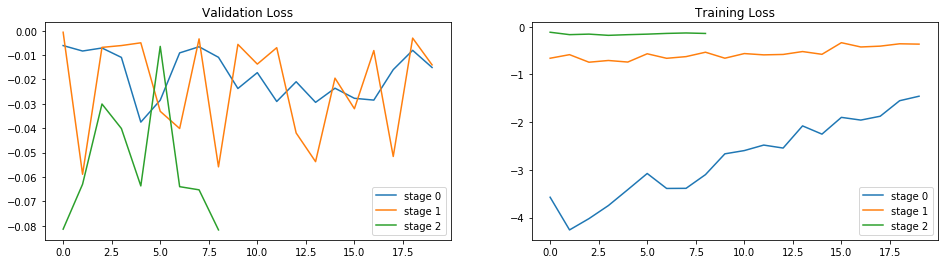

In [4]:
plot_training("results/rnnprop_0.5/summary.csv")

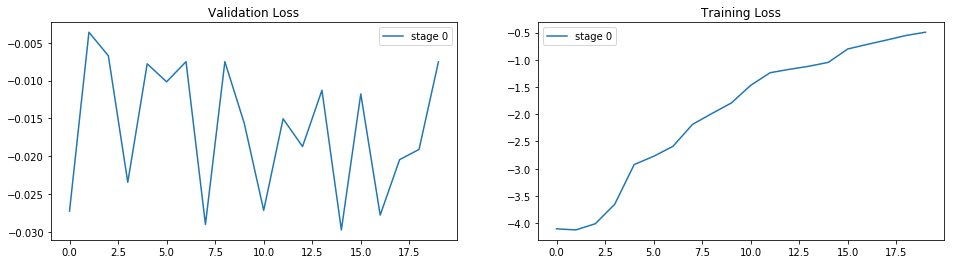

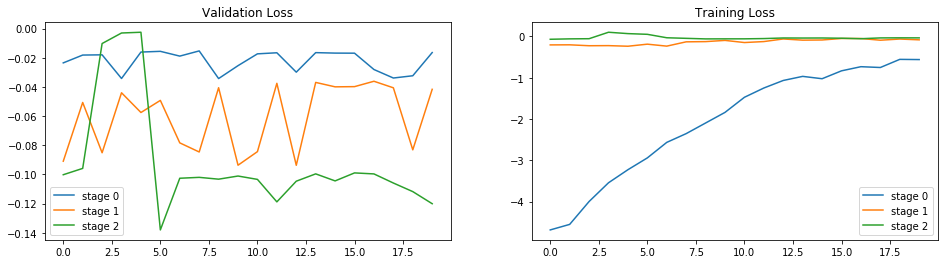

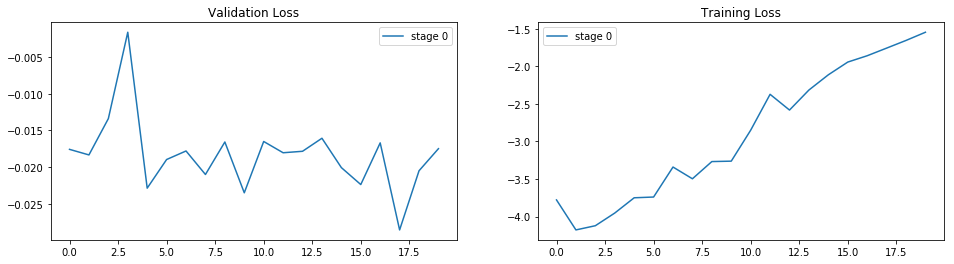

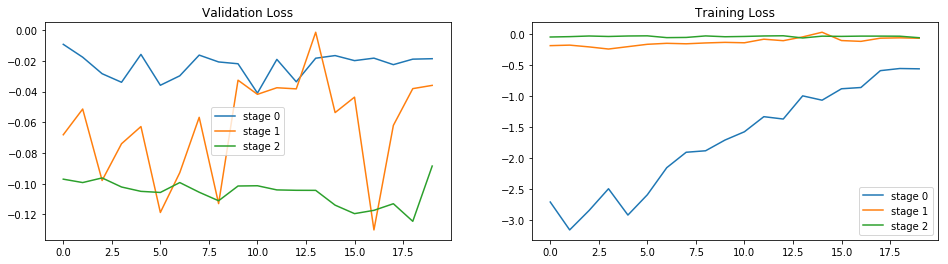

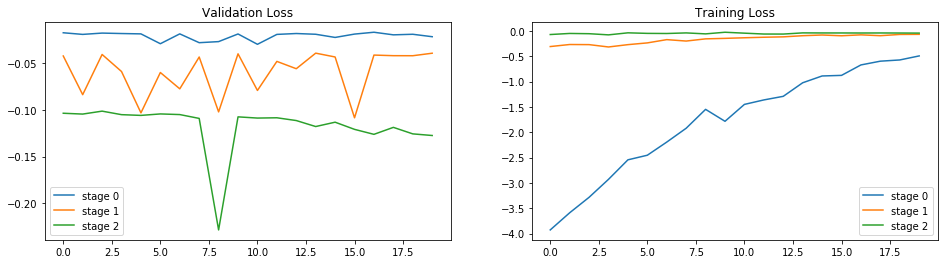

In [13]:
plot_training("1t_32b")
plot_training("1t_64b")
plot_training("1t_64b_gradual")
plot_training("1t_64b_sameopt")
plot_training("2t_64b")

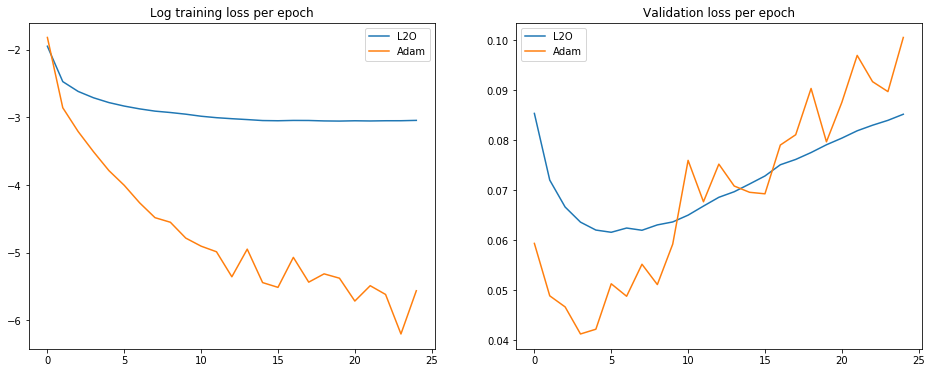

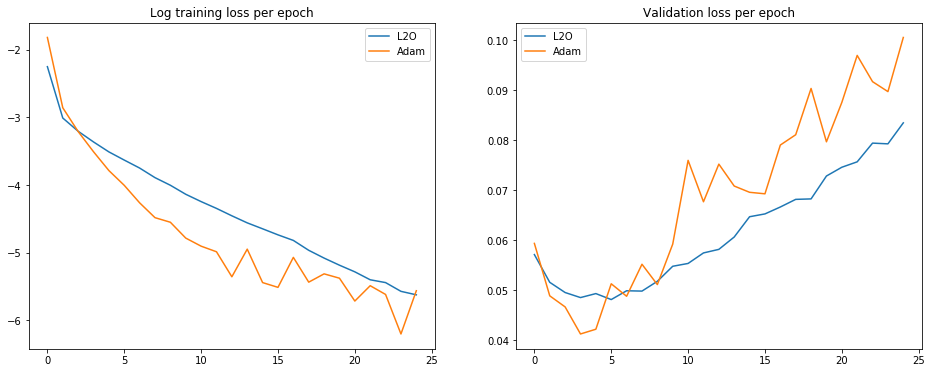

In [8]:
# plot_evaluation(["1t_32b", 0, 18])
plot_evaluation(["1t_64b", 2, 19])
# plot_evaluation(["1t_64b_gradual", 0, 18])
plot_evaluation(["1t_64b_sameopt", 2, 19])
# plot_evaluation(["2t_64b", 0, 19])

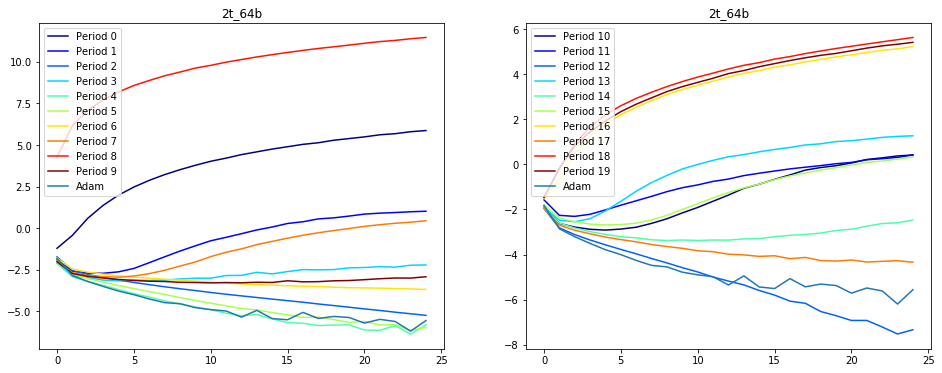

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
compare_set(axs[0], "2t_64b", 2, periods=list(range(10)))
compare_set(axs[1], "2t_64b", 2, periods=list(range(10, 20)))


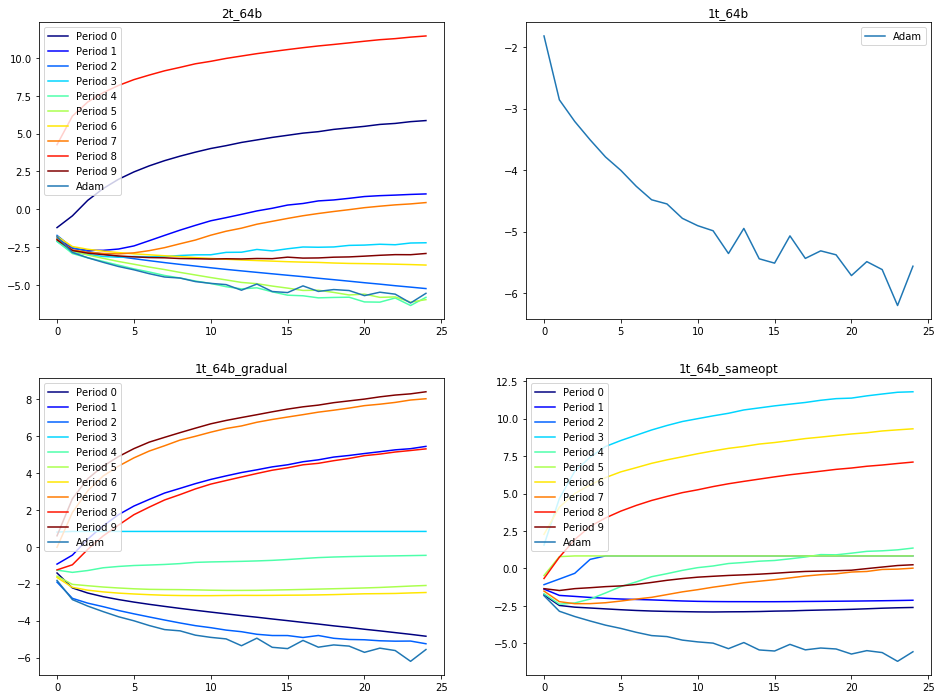

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
compare_set(axs[0][0], "2t_64b", 2, periods=list(range(10)))
compare_set(axs[0][1], "1t_64b", 2, periods=list(range(10)))
compare_set(axs[1][0], "1t_64b_gradual", 0, periods=list(range(10)))
compare_set(axs[1][1], "1t_64b_sameopt", 0, periods=list(range(10)))

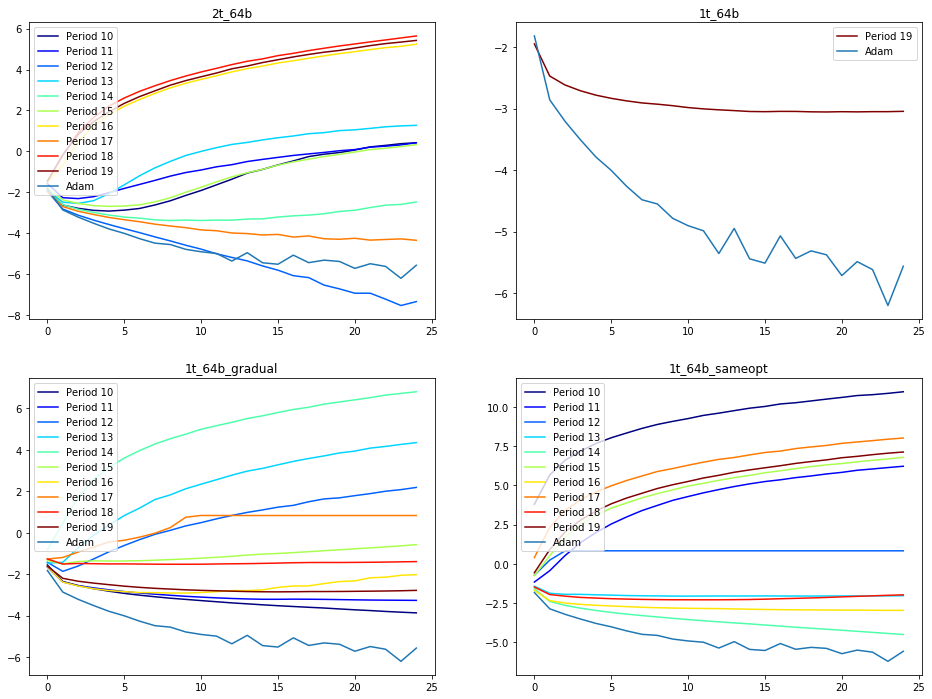

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
compare_set(axs[0][0], "2t_64b", 2, periods=list(range(10, 20)))
compare_set(axs[0][1], "1t_64b", 2, periods=list(range(10, 20)))
compare_set(axs[1][0], "1t_64b_gradual", 0, periods=list(range(10, 20)))
compare_set(axs[1][1], "1t_64b_sameopt", 0, periods=list(range(10, 20)))

In [11]:
load_evaluation("1t_64b_sameopt", 2, 19)

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,epoch_time
0,0.105203,0.968017,0.057100,0.9819,26.960474
1,0.049277,0.985133,0.051550,0.9835,46.765921
2,0.040520,0.988233,0.049509,0.9848,66.665232
3,0.034605,0.989583,0.048499,0.9839,86.640530
4,0.029869,0.991517,0.049297,0.9842,106.566536
5,0.026469,0.992800,0.048101,0.9850,126.492178
6,0.023527,0.993567,0.049862,0.9847,146.329285
7,0.020419,0.994450,0.049795,0.9851,166.299430
8,0.018246,0.995000,0.051753,0.9838,186.174779
9,0.015971,0.996083,0.054762,0.9837,206.101167
